# Preprocesamiento

Se realizará el preprocesamiento del dataset, junto con la elección y extracción de features.

### Número de canales y frecuencia de sampleo

Se utilizará un solo canal por audio, llevando todos a mono. Por default, la librería librosa levanta los archivos en mono. Para el tipo de grabaciones que se están analizando, no es de gran interés que sean estéreo.

Por default, librosa resamplea los audios a 22050 Hz, por lo que en una primera etapa se hará uso de esto. Posteriormente, se intentará resampleando a 44.1 kHz.

In [1]:
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import os
#plt.style.use('dark_background')

### Profundidad de bits

Librosa normaliza la entrada a valores entre -1 y 1, por lo que se aprovechará esto. Por ende, los archivos van a ser normalizados en ese rango de amplitudes.

In [2]:
filename = '../Jupyter Notebooks/Audio Samples/24074-1-0-4.wav'

audio_sample, freq_sampleo = lb.load(filename)
print 'Rango de amplitudes:', np.min(audio_sample), 'a', np.max(audio_sample)
print 'Frecuencia de sampleo:',freq_sampleo

Rango de amplitudes: -0.32558098 a 0.33160803
Frecuencia de sampleo: 22050


Para el resampleo a 22050Hz, Librosa utiliza una ventana de Kaiser para llegar a la interpolación deseada (se denomina _Kaiser best_ en su documentación). Esta ventana tiene un $\beta = 15$ y una frecuencia de cutoff de aproximadamente 95% de la frecuencia de Nyquist (0.95 de la misma). 

Además, puedo plotear y verificar que efectivamente librosa va a levantar uno solo de los canales de audio

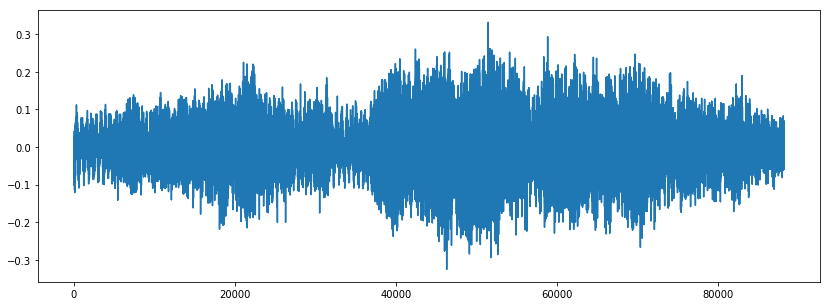

In [3]:
plt.figure(figsize=(14, 5))
plt.plot(audio_sample)
plt.show()

## Coeficientes Cepstrales de las Frecuencias de Mel

En primer lugar, se trabajará con los __MFCC__ (Mel-Frequency Cepstral Coefficients). Los mismos permiten representar el "espectrograma" (cepstrum) de Mel. Para calcularlos, se suelen seguir los siguientes pasos:

    0) Pre-Enfasis: en este paso, se puede aplicar filtro para amplificar las frecuencias altas.
        - De esta manera se balancea un poco el espectro, ya que las frecuencias más altas tienden a tener menor amplitud que las bajas.
        - Mejora la SNR.
    1) Separar la señal en diferentes bloques a través de la utilización de ventanas.
    2) Aplicar la Transformada Discreta de Fourier a cada bloque de muestras.
    3) Obtener la potencia espectral de la señal (|(FFT)²|).
    4) Aplicar el banco de filtros correspondiente a la Escala de Mel al espectro obtenido.
    5) Calcular las energías.
    6) Tomar el logaritmo de todas las energías de cada frecuencia resultante en la escala de Mel.
    7) Aplicar la Transformada Discreta del Coseno a los logaritmos obtenidos.
    8) Los coeficientes MFCC corresponden a los coeficientes de la DCT resultante; es decir, son las amplitudes del espectro que se obtiene.

<div>
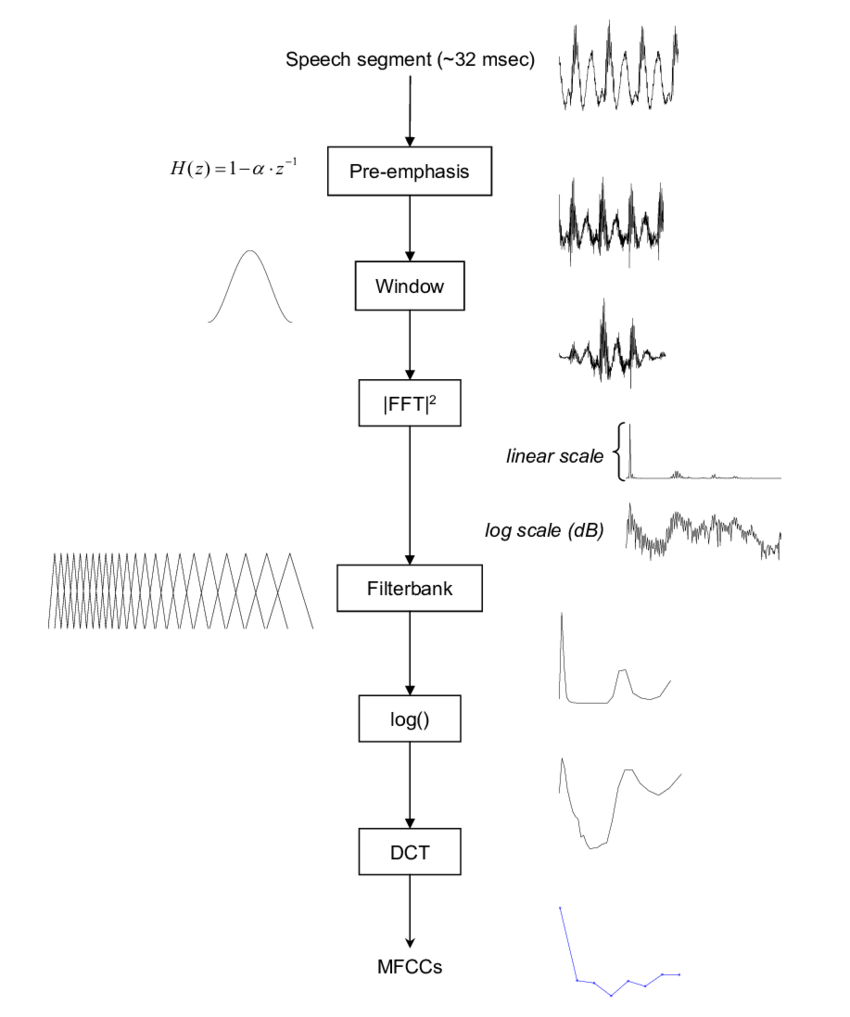
</div>

Source: _Acoustical Modeling for Speech Recognition: Long Units and Multi-Modeling_, Messina, R.

Se puede hablar sobre el espectro resultante, denominado __Cepstrum__. En primer lugar, se toma el logaritmo de la magnitud de la Transformada de Fourier de cualquier señal (en este caso, audio). Luego, se obtiene el espectro a partir de la Transformada Discreta del Coseno de este logaritmo (paso del dominio _frequency_ al dominio _quefrency_). Este espectro del logaritmo del espectro original, da por resultado el __Cepstrum__.  El mismo nos permite observar picos donde exista un elemento periódico en la señal original.

Otro concepto fundamental es la __Escala de Mel__. La misma permite relacionar la frecuencia percibida por el ser humano de un determinado sonido con la frecuencia real del mismo (es una escala perceptual de _pitch_). La escala presenta un mapeo de Hertz a Mels de manera _no lineal_ (se podría considerar aproximadamente lineal hasta la frecuencia de 1 kHz y logarítmico desde 1 kHz en adelante); de esta manera, escala las frecuencias para acercarse mejor a lo que un ser humano puede escuchar (los seres humanos son mejores identificando pequeños cambios en el habla a frecuencias más bajas). Una frecuencia medida en Hertz puede convertirse a la escala de Mel según la siguiente ecuación:

$$Mel (f) = 2595 log \left(1 + \dfrac{f}{700}\right)$$

La envolvente de la potencia espectral de una señal de habla se puede relacionar con la formación de sonidos en el tracto vocal. Los valores de los MFCC representan de manera precisa esta envolvente. Estos coeficientes son los que finalmente conforman el __Cepstrum de Mel__.

El mapeo no lineal de Hertz a Mel puede ser observado a continuación:

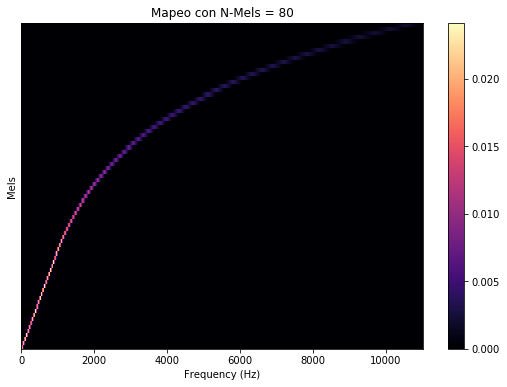

In [4]:
mel_80 = librosa.filters.mel(sr=freq_sampleo, n_fft=2048, n_mels=80)

plt.figure(figsize=(9, 6));

librosa.display.specshow (mel_80, x_axis='linear')
plt.ylabel('Mels')
plt.xlabel ('Frequency (Hz)')
plt.colorbar()
plt.title('Mapeo con N-Mels = 80')
plt.show()


Si se cambia el número de Mels resultantes, se puede observar el efecto de mejor manera:

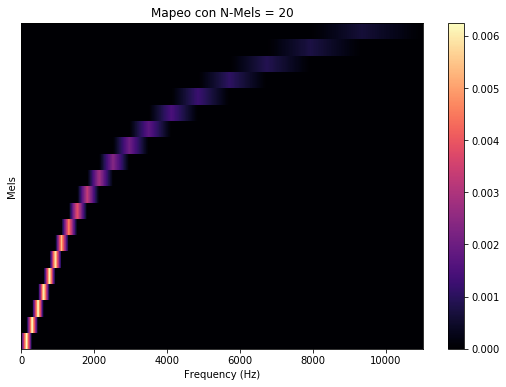

In [5]:
mel_20 = librosa.filters.mel(sr=freq_sampleo, n_fft=2048, n_mels=20)

plt.figure(figsize=(9, 6));

librosa.display.specshow (mel_20, x_axis='linear')
plt.ylabel('Mels')
plt.xlabel ('Frequency (Hz)')
plt.colorbar()
plt.title('Mapeo con N-Mels = 20')
plt.show()

Finalmente, los valores de los coeficientes MFCC pueden ser calculados con la siguiente expresión:

$$mfcc_m [n] = \dfrac{1}{R}\sum_{r=1}^{R} log (MF_m[n]) cos \left[ \dfrac{2\pi}{R} \left(r+\dfrac{1}{2} \right) n       \right]$$

_R_ se refiere a la cantidad de filtros en el banco de filtros triangulares utilizados. En función del ancho de banda de la señal a analizar, se elige el número de filtros (las recomendaciones varían según los autores). Librosa utiliza filtros de igual energía o altura (hay varios métodos para generar el banco de filtros).

## Extracción de Features

Se extraerán los Coeficientes Cepstrales de las frecuencias de Mel (MFCCs) para cada audio. En primer lugar, se hará una prueba con la muestra de audio para testear cómo funciona. Para esto, se tratarán de encontrar 40 coeficientes (es decir, 40 amplitudes del espectro resultante).

In [7]:
mfccs = librosa.feature.mfcc(y = audio_sample, sr = freq_sampleo, n_mfcc=40)
print (mfccs.shape)

(40, 173)


Se puede observar que se obtienen 40 MFCCs para 173 frames. Estos frames están relacionados con la cantidad de puntos de la ventana de la DFT utilizada (512) y la duración del audio (aproximadamente 4 segundos). Por ende, esto resulta en:

$$ 22050 * 4 /512 = 173 $$

Puedo revisar también el espectrograma resultante:

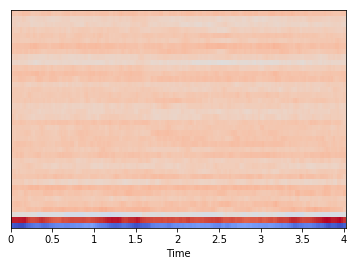

In [8]:
librosa.display.specshow(mfccs, sr = freq_sampleo, x_axis='time')

### Extracción de features para cada audio del dataset

Se define una función para extraer el feature (en este caso, los coeficientes MFCC) de cada audio.

In [10]:
def extract_features (file_name):
    # En primer lugar, voy a testear un resampleo kaiser_fast para que sea mas rapido
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 40)
    mfccsscaled = np.mean(mfccs.T,axis=0)

    return mfccsscaled

Se iterará por todos los audios para extraer los features correspondientes:

In [12]:
# Defino el path absoluto donde estan localizados todos los audios

dataset_path = '/media/diego/4A64372E64371BDF/Downloads/Guitar Pro 5.2/UrbanSound8K/audio/'

# Leo la metadata 

metadata = pd.read_csv('../Jupyter Notebooks/Metadata/UrbanSound8K.csv')

# Preparo donde voy a colocar los features

features = []

# Itero a través de cada audio para obtener los nombres de los archivos y las clases

for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    class_label = row ["class_name"]
    
    # Extraigo los features para cada archivo
    
    data = extract_features (file_name)
    
    #Appendo en features []
    
    features.append([data, class_label])
    
# Convierto a un pandas dataframe

features_df = pd.DataFrame(features, columns=['features','class_label'])



In [13]:
print (len(features_df))
print features_df.head()

8732
                                            features       class_label
0  [-215.80638278973197, 71.6541209402327, -131.8...          dog_bark
1  [-424.7250785602361, 110.59036846310586, -54.1...  children_playing
2  [-459.57186507199793, 122.80929720176647, -47....  children_playing
3  [-414.5298406082568, 102.87144059361601, -36.6...  children_playing
4  [-447.35827792776485, 115.04796200959304, -53....  children_playing


### Convierto los datos de categorical a numerical

Se utiliza el LabelEncoder de sklearn para pasar de categorical a numerical data.

In [29]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convierto los features y sus correspondientes class_labels a numpy arrays

X = np.array (features_df.features.tolist())
y = np.array (features_df.class_label.tolist())

# Transformo las classification labels a numérico

label_encoder = LabelEncoder()

# Convierto el vector y (donde tengo las class_labels) a una matriz de clases binarias (0s y 1s).
# Con label_encoder las transformo a enteros, y con to_categorical paso esos enteros a la matriz binaria.

yy = to_categorical(label_encoder.fit_transform(y))

## Spliteo el dataset

Se utiliza la función de sklearn __train_test_split__ para dividir mi dataset en set de entrenamiento y set de testeo. El testing set va a ser del 20% y se va a setear un random state para el mismo.

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size = 0.2, random_state = 42) 

## Finalización del preprocesamiento

Para finalizar el preprocesamiento, storeo la data para utilizar en notebooks posteriores

In [31]:
%store x_train 
%store x_test 
%store y_train 
%store y_test 
%store yy 
%store label_encoder

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'label_encoder' (LabelEncoder)
